In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras import utils, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

2023-04-24 20:57:02.629835: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 20:57:02.680842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 20:57:03.614276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Loading

In [2]:
dataset = utils.image_dataset_from_directory(
    './figs',
    labels="inferred",
    label_mode="int",
    class_names=['class0', 'class1', 'class2', 'class3'],
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=True,
    seed=109,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
trainset, valset = dataset

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.


2023-04-24 20:57:08.832508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 20:57:08.862206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 20:57:08.862467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-04-24 20:57:17.385526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:57:17.385964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


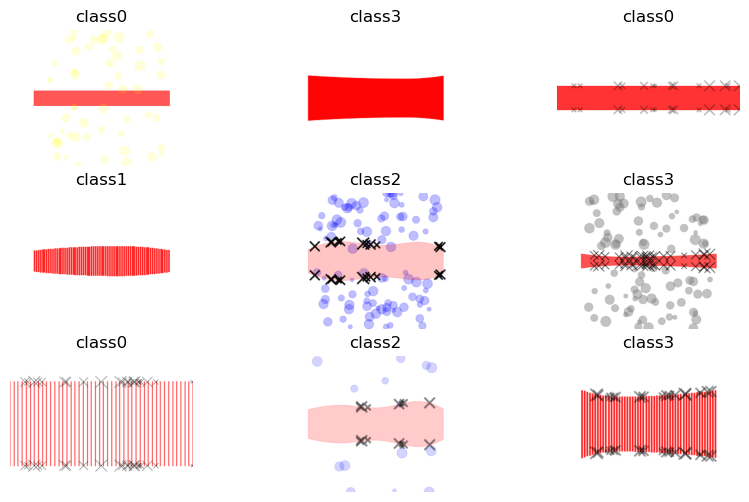

In [3]:
class_names = trainset.class_names
fig, ax = plt.subplots(3, 3, figsize=(10, 6));
for images, labels in trainset.take(1):
    for i in range(9):
        j = i//3; k = i%3
        ax[j][k].imshow(images[i].numpy().astype("uint8"))
        ax[j][k].set_title(class_names[labels[i]])
        ax[j][k].axis("off")

## Configure the Dataset for Performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.cache().prefetch(buffer_size=AUTOTUNE)
valset = valset.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
##normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = trainset.map(lambda x, y: (normalization_layer(x), y))
normalized_val = valset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-04-24 20:57:22.497667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:57:22.498139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]


0.0 1.0


2023-04-24 20:57:23.152618: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Build the AlexNet Model

In [6]:
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(258, 347, 3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))


In [ ]:
AlexNet.summary()

In [ ]:
##compile the model
AlexNet.compile(
  optimizer=optimizers.Adam(learning_rate=5e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [14]:
#define early stopping
es = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=0)
##define automatic saving 
save = ModelCheckpoint(
    "./models/alexnet_adam1e-4",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
)

In [15]:
##fit 
%time
AlexNet.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=40, callbacks=[es, save]  
)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Epoch 1/40


2023-03-30 23:20:00.463884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-30 23:20:26.136395: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-30 23:20:33.383391: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562dcdc87ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-30 23:20:33.383443: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-30 23:20:33.850478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-30 23:20:36.193991: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-30 23:20:36.242981: I tensorflow/compiler/jit/xla_compilation_cache.cc:477

100/100 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.5989
Epoch 1: val_accuracy improved from -inf to 0.32063, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 120s 403ms/step - loss: 1.0085 - accuracy: 0.5989 - val_loss: 1.3842 - val_accuracy: 0.3206
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.8731
Epoch 2: val_accuracy improved from 0.32063 to 0.52000, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 391ms/step - loss: 0.5678 - accuracy: 0.8731 - val_loss: 1.2181 - val_accuracy: 0.5200
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.9466
Epoch 3: val_accuracy improved from 0.52000 to 0.76688, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 38s 381ms/step - loss: 0.4471 - accuracy: 0.9466 - val_loss: 0.9397 - val_accuracy: 0.7669
Epoch 4/40
100/100 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.9803
Epoch 4: val_accuracy improved from 0.76688 to 0.85312, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 38s 384ms/step - loss: 0.3867 - accuracy: 0.9803 - val_loss: 0.7150 - val_accuracy: 0.8531
Epoch 5/40
100/100 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.9945
Epoch 5: val_accuracy improved from 0.85312 to 0.92437, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 386ms/step - loss: 0.3485 - accuracy: 0.9945 - val_loss: 0.5306 - val_accuracy: 0.9244
Epoch 6/40
100/100 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.9973
Epoch 6: val_accuracy improved from 0.92437 to 0.95187, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 38s 386ms/step - loss: 0.3255 - accuracy: 0.9973 - val_loss: 0.4296 - val_accuracy: 0.9519
Epoch 7/40
100/100 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.9994
Epoch 7: val_accuracy did not improve from 0.95187
100/100 [==============================] - 19s 188ms/step - loss: 0.3081 - accuracy: 0.9994 - val_loss: 0.3756 - val_accuracy: 0.9513
Epoch 8/40
100/100 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9994
Epoch 8: val_accuracy improved from 0.95187 to 0.96750, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 396ms/step - loss: 0.2965 - accuracy: 0.9994 - val_loss: 0.3636 - val_accuracy: 0.9675
Epoch 9/40
100/100 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 1.0000
Epoch 9: val_accuracy did not improve from 0.96750
100/100 [==============================] - 19s 187ms/step - loss: 0.2875 - accuracy: 1.0000 - val_loss: 0.3951 - val_accuracy: 0.9581
Epoch 10/40
100/100 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.96750 to 0.97000, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 394ms/step - loss: 0.2808 - accuracy: 1.0000 - val_loss: 0.3570 - val_accuracy: 0.9700
Epoch 11/40
100/100 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 1.0000
Epoch 11: val_accuracy improved from 0.97000 to 0.97188, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 390ms/step - loss: 0.2755 - accuracy: 1.0000 - val_loss: 0.3947 - val_accuracy: 0.9719
Epoch 12/40
100/100 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 1.0000
Epoch 12: val_accuracy improved from 0.97188 to 0.97250, saving model to ./models/alexnet_adam1e-4


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 388ms/step - loss: 0.2704 - accuracy: 1.0000 - val_loss: 0.3608 - val_accuracy: 0.9725
Epoch 13/40
100/100 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.97250
100/100 [==============================] - 19s 192ms/step - loss: 0.2652 - accuracy: 1.0000 - val_loss: 0.3957 - val_accuracy: 0.9681
Epoch 14/40
100/100 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.97250
100/100 [==============================] - 19s 193ms/step - loss: 0.2611 - accuracy: 1.0000 - val_loss: 0.3924 - val_accuracy: 0.9594
Epoch 15/40
100/100 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.97250
100/100 [==============================] - 19s 193ms/step - loss: 0.2582 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.9588
Epoch 16/40
100/1

INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 394ms/step - loss: 0.2544 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9762
Epoch 17/40
100/100 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.97625
100/100 [==============================] - 19s 188ms/step - loss: 0.2513 - accuracy: 1.0000 - val_loss: 0.3847 - val_accuracy: 0.9481
Epoch 18/40
100/100 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.97625
100/100 [==============================] - 19s 193ms/step - loss: 0.2485 - accuracy: 1.0000 - val_loss: 0.3533 - val_accuracy: 0.9700
Epoch 19/40
100/100 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 1.0000
Epoch 19: val_accuracy did not improve from 0.97625
100/100 [==============================] - 19s 192ms/step - loss: 0.2450 - accuracy: 1.0000 - val_loss: 0.3812 - val_accuracy: 0.9606
Epoch 20/40
100/1

INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 396ms/step - loss: 0.2290 - accuracy: 1.0000 - val_loss: 0.3014 - val_accuracy: 0.9787
Epoch 26/40
100/100 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 0.97875
100/100 [==============================] - 19s 188ms/step - loss: 0.2268 - accuracy: 1.0000 - val_loss: 0.3034 - val_accuracy: 0.9762
Epoch 27/40
100/100 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 0.97875
100/100 [==============================] - 19s 193ms/step - loss: 0.2246 - accuracy: 1.0000 - val_loss: 0.3001 - val_accuracy: 0.9769
Epoch 28/40
100/100 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.97875
100/100 [==============================] - 19s 191ms/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 0.3039 - val_accuracy: 0.9725
Epoch 29/40
100/1

INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


INFO:tensorflow:Assets written to: ./models/alexnet_adam1e-4/assets


100/100 [==============================] - 39s 391ms/step - loss: 0.2148 - accuracy: 1.0000 - val_loss: 0.2750 - val_accuracy: 0.9800
Epoch 32/40
100/100 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.98000
100/100 [==============================] - 19s 185ms/step - loss: 0.2125 - accuracy: 1.0000 - val_loss: 0.2845 - val_accuracy: 0.9762
Epoch 33/40
100/100 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 0.98000
100/100 [==============================] - 19s 191ms/step - loss: 0.2102 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.9762
Epoch 34/40
100/100 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 1.0000
Epoch 34: val_accuracy did not improve from 0.98000
100/100 [==============================] - 19s 193ms/step - loss: 0.2082 - accuracy: 1.0000 - val_loss: 0.2983 - val_accuracy: 0.9675
Epoch 35/40
100/1

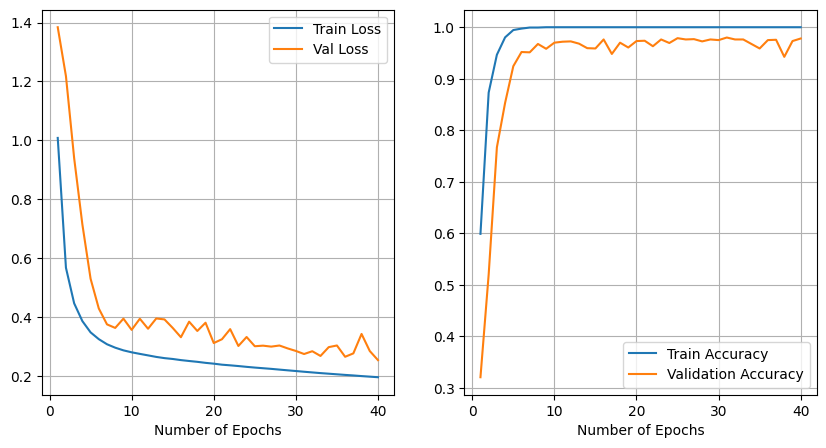

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(range(1, len(AlexNet.history.history['loss'])+1), AlexNet.history.history['loss'], 
           label='Train Loss');
ax[0].plot(range(1, len(AlexNet.history.history['val_loss'])+1), 
         AlexNet.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(AlexNet.history.history['accuracy'])+1), AlexNet.history.history['accuracy'],
          label = 'Train Accuracy')
ax[1].plot(range(1, len(AlexNet.history.history['val_accuracy'])+1), AlexNet.history.history['val_accuracy'], 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");

In [17]:
max(AlexNet.history.history['val_accuracy'])

0.9800000190734863

In [7]:
##load the model
AlexNet = tf.keras.models.load_model("./models/alexnet_adam1e-4")

In [8]:
##test on the validation image
AlexNet.evaluate(normalized_val)

2023-04-24 20:57:47.288189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:57:47.288558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 20:57:48.718071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 20:57:49.421022: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 5s 62ms/step - loss: 0.2750 - accuracy: 0.9800


[0.27502110600471497, 0.9800000190734863]

## Now Test on the Test Image

In [9]:
##load the test image
testset1 = utils.image_dataset_from_directory(
    './test/class1',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset2 = utils.image_dataset_from_directory(
    './test/class2',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset3 = utils.image_dataset_from_directory(
    './test/class3',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1800 files belonging to 1 classes.
Found 1414 files belonging to 1 classes.
Found 1800 files belonging to 1 classes.


In [10]:
##normalize the testset
normalized_testset1 = testset1.map(lambda x: normalization_layer(x))
normalized_testset2 = testset2.map(lambda x: normalization_layer(x))
normalized_testset3 = testset3.map(lambda x: normalization_layer(x))

In [11]:
##predict
prediction1 = np.array([x.argmax() for x in AlexNet.predict(normalized_testset1)])
prediction2 = np.array([x.argmax() for x in AlexNet.predict(normalized_testset2)]) 
prediction3 = np.array([x.argmax() for x in AlexNet.predict(normalized_testset3)])

2023-04-24 20:58:01.591203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:58:01.591501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


 1/23 [>.............................] - ETA: 3s

2023-04-24 20:58:04.854861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:58:04.855134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


 1/29 [>.............................] - ETA: 4s

2023-04-24 20:58:07.278774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:58:07.279139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 3s 94ms/step


In [14]:
print(prediction1.sum()) ##alexnet classifies all class1 test images as class 0
print(prediction2.sum())
print(prediction3.sum())

0
12
15


In [12]:
print(np.unique(prediction1))
print("Number of prediction 0: {}".format((prediction1==0).sum()))
print("Number of prediction 1: {}".format((prediction1==1).sum()))
print("Number of prediction 2: {}".format((prediction1==2).sum()))
print("Number of prediction 3: {}".format((prediction1==3).sum()))

[0]
Number of prediction 0: 1800
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 0


In [13]:
print(np.unique(prediction2))
print("Number of prediction 0: {}".format((prediction2==0).sum()))
print("Number of prediction 1: {}".format((prediction2==1).sum()))
print("Number of prediction 2: {}".format((prediction2==2).sum()))
print("Number of prediction 3: {}".format((prediction2==3).sum()))

[0 2]
Number of prediction 0: 1408
Number of prediction 1: 0
Number of prediction 2: 6
Number of prediction 3: 0


In [19]:
5/1800

0.002777777777777778

In [14]:
print(np.unique(prediction3))
print("Number of prediction 0: {}".format((prediction3==0).sum()))
print("Number of prediction 1: {}".format((prediction3==1).sum()))
print("Number of prediction 2: {}".format((prediction3==2).sum()))
print("Number of prediction 3: {}".format((prediction3==3).sum()))

[0 3]
Number of prediction 0: 1795
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 5


## Use Saliency Map to Examine the Model's Attention

In [22]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore

def get_img(batch, index, img_set):
    i = index // batch; j = index % batch
    batch_ = list(iter(img_set.skip(index).take(1)))[0]
    img = batch_[0][j]
    label = batch_[1][j]
    return img, int(label)

##our model returns probability, so need to transform back to logit
def model_modifier(model):
    model.layers[-1].activation=tf.keras.activations.linear

def generate_saliency_map(model, modifier, img, class_index, smooth=0):
    saliency = Saliency(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_index])
    saliency_map = saliency(score, img, smooth)
    return saliency_map

def generate_gradcam(model, modifier, img, class_idx):
    gradcam = Gradcam(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_idx])
    results = gradcam(score, img)
    return results

##this function plot the saliency maps when the prediction is correct
def plot_saliency_correct(model, modifier, img, class_idx):
    sg_saliency = generate_saliency_map(model, modifier, img, class_idx, smooth=1)[0]
    gc_saliency = generate_gradcam(model, modifier, img, class_idx)[0]
    fig, ax = plt.subplots(1, 2, figsize=(8, 4));
    ax[0].imshow(sg_saliency, cmap='gist_heat', alpha=1);
    ax[0].imshow(img, alpha=0.3);
    ax[0].axis('off');
    ax[0].set_title("Smooth-Grad Saliency Map of class {}".format(class_idx));
    ax[1].imshow(gc_saliency, cmap='gist_heat', alpha=1);
    ax[1].imshow(img, alpha=0.3);
    ax[1].axis('off');
    ax[1].set_title("GradCam Saliency Map of class {}".format(class_idx));
    
##this function plot the saliency maps when the prediction is incorrect
def plot_saliency_wrong(model, modifier, img, real_class, pred_class):
    sg_saliency_real = generate_saliency_map(model, modifier, img, real_class, smooth=1)[0]
    gc_saliency_real = generate_gradcam(model, modifier, img, real_class)[0]
    sg_saliency_pred = generate_saliency_map(model, modifier, img, pred_class, smooth=1)[0]
    gc_saliency_pred = generate_gradcam(model, modifier, img, pred_class)[0]
    fig, ax = plt.subplots(2, 2, figsize=(8, 8));
    ax[0][0].imshow(sg_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][0].imshow(img, alpha=0.2);
    ax[0][0].axis('off');
    ax[0][0].set_title("Smooth-Grad Saliency Map of class {}".format(real_class));
    ax[0][1].imshow(gc_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][1].imshow(img, alpha=0.2);
    ax[0][1].axis('off');
    ax[0][1].set_title("GradCam Saliency Map of class {}".format(real_class));
    ax[1][0].imshow(sg_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][0].imshow(img, alpha=0.2);
    ax[1][0].axis('off');
    ax[1][0].set_title("Smooth-Grad Saliency Map of class {}".format(pred_class));
    ax[1][1].imshow(gc_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][1].imshow(img, alpha=0.2);
    ax[1][1].axis('off');
    ax[1][1].set_title("GradCam Saliency Map of class {}".format(pred_class));

### Examine How the Model sees the images in the train and validation Images first

In [24]:
one_batch_val = list(iter(normalized_val.skip(0).take(1)))
index0 = np.where(one_batch_val[0][1].numpy()==0)[0]
index1 = np.where(one_batch_val[0][1].numpy()==1)[0]
index2 = np.where(one_batch_val[0][1].numpy()==2)[0]
index3 = np.where(one_batch_val[0][1].numpy()==3)[0]

2023-04-04 14:48:22.207397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-04-04 14:48:22.207919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


In [38]:
val_img0 = one_batch_val[0][0][index0[12]]
val_img1 = one_batch_val[0][0][index1[0]]
val_img2 = one_batch_val[0][0][index2[0]]
val_img3 = one_batch_val[0][0][index3[0]]
single_pred0 = AlexNet.predict(np.expand_dims(val_img0, axis=0)).argmax()
single_pred1 = AlexNet.predict(np.expand_dims(val_img1, axis=0)).argmax()
single_pred2 = AlexNet.predict(np.expand_dims(val_img2, axis=0)).argmax()
single_pred3 = AlexNet.predict(np.expand_dims(val_img3, axis=0)).argmax()

1/1 [==============================] - 0s 26ms/step


Model correctly predicted 0


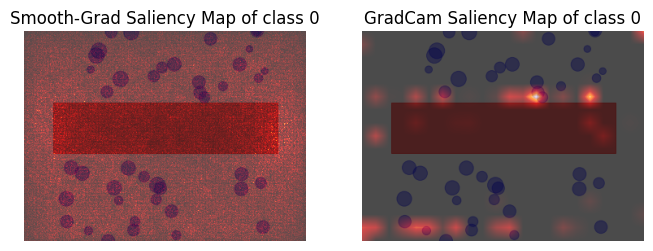

In [39]:
if single_pred0 == 0:
    print("Model correctly predicted 0")
    plot_saliency_correct(AlexNet, model_modifier, val_img0, 0)
else:
    print("Model misclassified as: {}, but shoud be 0".format(single_pred0))
    plot_saliency_wrong(AlexNet, model_modifier, val_img0, 0, single_pred0)

Model correctly predicted 1


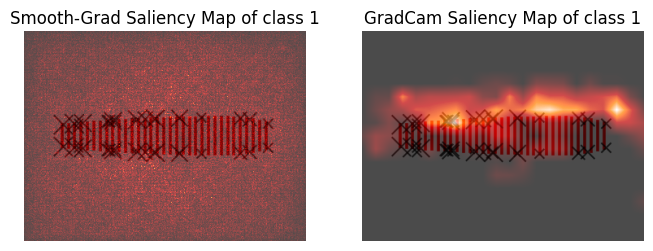

In [40]:
if single_pred1 == 1:
    print("Model correctly predicted 1")
    plot_saliency_correct(AlexNet, model_modifier, val_img1, 1)
else:
    print("Model misclassified as: {}, but shoud be 1".format(single_pred1))
    plot_saliency_wrong(AlextNet, model_modifier, val_img1, 1, single_pred1)

Model correctly predicted 2


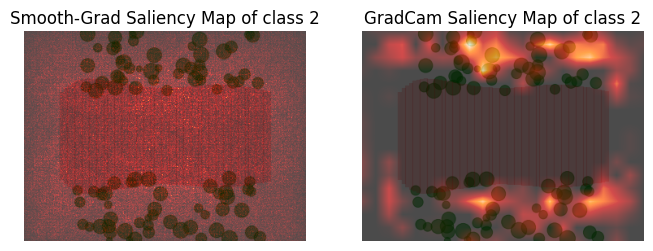

In [41]:
if single_pred2 == 2:
    print("Model correctly predicted 2")
    plot_saliency_correct(AlexNet, model_modifier, val_img2, 2)
else:
    print("Model misclassified as: {}, but shoud be 2".format(single_pred2))
    plot_saliency_wrong(AlexNet, model_modifier, val_img2, 2, single_pred2)

Model correctly predicted 3


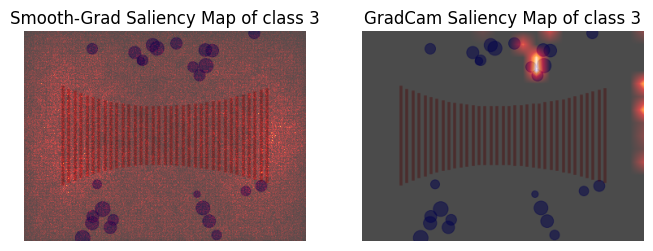

In [42]:
if single_pred3 == 3:
    print("Model correctly predicted 3")
    plot_saliency_correct(AlexNet, model_modifier, val_img3, 3)
else:
    print("Model misclassified as: {}, but shoud be 3".format(single_pred3))
    plot_saliency_wrong(AlexNet, model_modifier, val_img3, 3, single_pred3)

### Examine the test image
#### Test Image, class 1

2023-04-04 15:05:11.716141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:11.716639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


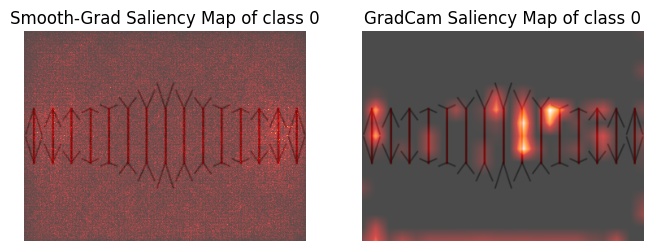

In [46]:
##correct classification example
index = np.where(prediction1==0)[0][20]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(AlexNet, model_modifier, img, 0)

#### Test Image, class 2

2023-04-04 15:05:54.870658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:54.871063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


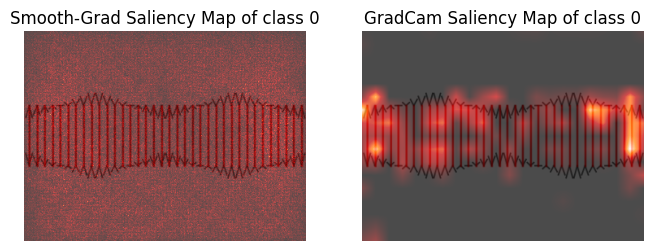

In [47]:
##correct classification example
index = np.where(prediction2==0)[0][1000]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(AlexNet, model_modifier, img, 0)

2023-04-04 15:06:37.941243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:06:37.941673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 26ms/step


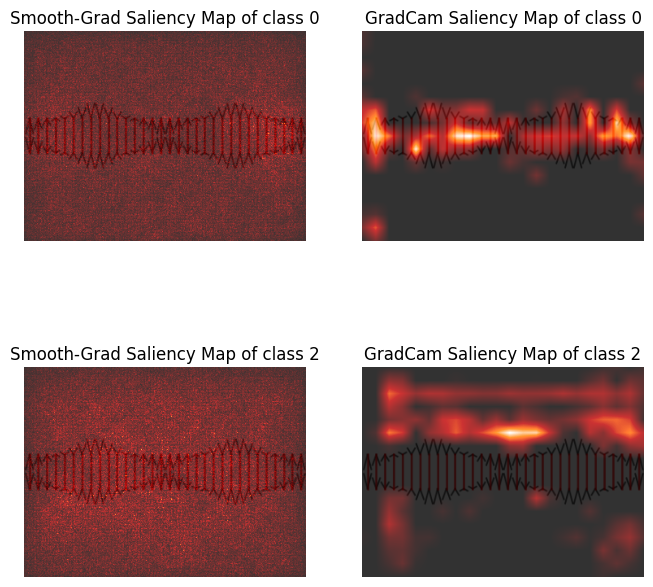

In [49]:
##misclassified as 2
index = np.where(prediction2==2)[0][-1]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = AlexNet.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(AlexNet, model_modifier, img, 0, pred)

#### Test Image, class 3

2023-04-04 15:07:58.150814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:07:58.151250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


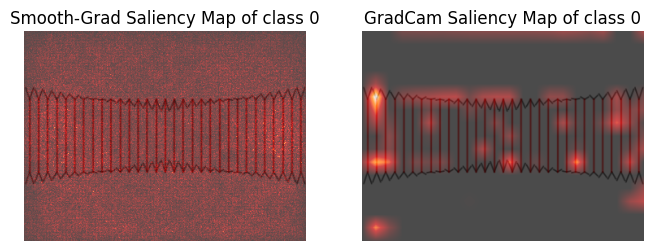

In [50]:
##correct classification example
index = np.where(prediction3==0)[0][1000]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(AlexNet, model_modifier, img, 0)

2023-04-04 15:08:56.658612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:08:56.659027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 26ms/step


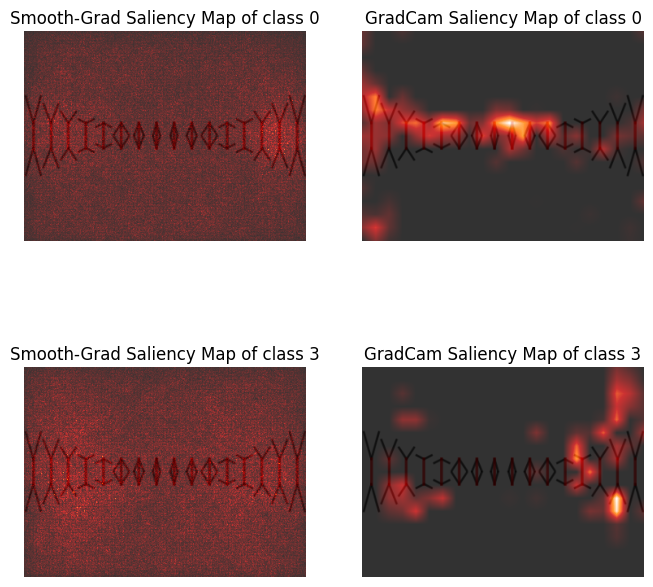

In [53]:
##misclassified as 3
index = np.where(prediction3==3)[0][0]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = AlexNet.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(AlexNet, model_modifier, img, 0, pred)

In [26]:
# test_1 = [1795, 5, 0, 0]; test_2 = [1166, 0, 242, 6]; test_3 = [1692, 0, 0, 108]
check_1 = [1799, 0, 1, 0]; check_2 = [1796, 0, 0, 0]; check_3 = [1799, 0, 0, 1]
xlabel = ["class0", 'class1', 'class2', 'class3']

<BarContainer object of 4 artists>

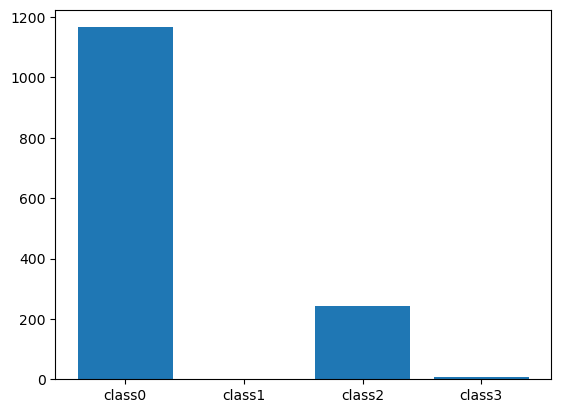

In [28]:
plt.bar(xlabel, test_2)